### Particle swarm optimization

This nb uses pso to approximate the optimum parameters needed to solve a function.\
The function describes a cannon shot, given an initial velocity $v_i$ and the 
shot angle $a$.

Mathematical formulation: 

Distance $= 2v_i^2 \cdot sin(a) \cdot cos(a) / 9.8$

In [8]:
import math
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
     

from deap import base
from deap import tools
from deap import creator
from deap import benchmarks

In [9]:
## the creator 
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Particle', np.ndarray, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best=None)

c:\Users\pnmue\anaconda3\envs\evol_DL\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\pnmue\anaconda3\envs\evol_DL\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [10]:
## pso functions

def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(np.random.uniform(pmin, pmax, size))
    part.speed = np.random.uniform(smin, smax, size)
    part.smin = smin
    part.smax = smax
    
    return part

def update_particle(part, best, phi1, phi2):
    # offset the particles by some random amount
    u1 = np.random.uniform(0, phi1, len(part))
    u2 = np.random.uniform(0, phi2, len(part))
    
    # calc. the speed offset in two dimensions
    v_u1 = u1 * (part.best - part)
    v_u2 = u2 * (best - part)
    
    part.speed += v_u1 + v_u2
    
    # enumerate through speeds and then adjust
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
        
    part += part.speed  

In [11]:
## evaluation function
# target distance
distance = 575 #@param {type:"slider", min:10, max:1000, step:5} 

def evaluate(individual):
    # only allow positive values since the velocity is squared in the 
    # target equation (see picture above)
    v = individual[0] if individual[0] > 0 else 0 # velocity
    
    # convert degree angle into radians 
    a = individual[1] * math.pi / 180 # angle to radius
    
    # return squared error from the distance to the calculated value
    return ((2 * v**2 * math.sin(a) * math.cos(a)) / 9.8 - distance)**2,

In [12]:
## the toolbox 

toolbox = base.Toolbox()

# register the generate fn to generate a new particle
toolbox.register('particle', generate, size=2, pmin=-6, pmax=6, smin=-3, smax=3)    

# register the particle as individual in a population
toolbox.register('population', tools.initRepeat, list, toolbox.particle)

# register the update_particle function to update the particle
toolbox.register('update', update_particle, phi1=200, phi2=200)     

# register the fn to evaluate the fitness of the individuals
toolbox.register('evaluate', evaluate)

In [13]:
## plot the expression tree

def plot_pop(pop, g):
    xs = [x for x, _ in pop] 
    ys = [y for _, y in pop]
    
    plt.figure(figsize=(12,5))
    plt.scatter(xs, ys)
    plt.xlabel('Velocity')
    plt.ylabel('Angle')
    plt.xlim(10.0, 80.0)
    plt.ylim(10.0, 50.0)
    plt.grid()
    plt.show()  
    
    return xs, ys

[32.6277349  32.55031013]


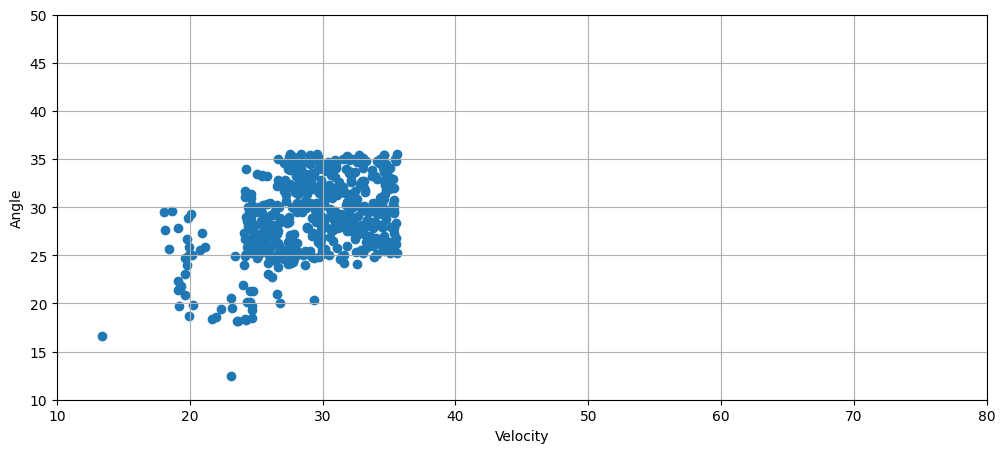

9  	500  	-269988	-324846	-227022	19691.9


In [14]:
## run the evolution

pop = toolbox.population(n=500)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('avg', np.mean)
stats.register('min', np.min)
stats.register('max', np.max)
stats.register('std', np.std)

logbook = tools.Logbook()
logbook.header = ['gen', 'evals'] + stats.fields    

GEN = 100
best = None

all_xs = []
all_ys = []

for g in range(GEN):
    # cycle thorugh particles in population
    for part in pop:
        
        part.fitness.values = tuple(np.subtract((0,), toolbox.evaluate(part)))
        
        # check for best fitness in particles
        if part.best is None or part.best.fitness < part.fitness:
            part.best = creator.Particle(part)
            part.best.fitness.values = part.fitness.values

        # check if it is better than the best particle
        if best is None or best.fitness < part.fitness:
            best = creator.Particle(part)
            best.fitness.values = part.fitness.values

    # loop through the population and update the toolbox
    for part in pop:
        toolbox.update(part, best)

    xs, ys = plot_pop(pop, g)
    all_xs.append([xs])
    all_ys.append([ys])
    
    
    if (g+1) % 5 == 0:
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        clear_output()
        print(best)
        _, _ = plot_pop(pop, g)
        print(logbook.stream)   
        time.sleep(1)

In [ ]:
## evaluate solution

v, a = best
a = a * math.pi / 180  #angle to radians
distance_sol = (2*v**2 * math.sin(a) * math.cos(a))/9.8
print(distance_sol, '  Target distance: ', distance)